In [164]:
import numpy as np
import networkx as nx
from networkx.generators.degree_seq import random_degree_sequence_graph
from networkx.algorithms.graphical import is_graphical
from networkx.utils.random_sequence import powerlaw_sequence
import matplotlib.pyplot as plt
plt.style.use('../figures/norm2.mplstyle')
from ldpc.code_util import *
from ldpc.mod2 import *
from bposd.hgp import hgp
from bposd.css import css_code, compute_code_distance
import sys, os

def read_pc(filepath):
    """
    Read parity check matrix from file.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    pc = []
    for line in lines:
        row = [int(x) for x in line.split()]
        pc.append(row)
    return np.array(pc, dtype=np.uint8)

readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/rgg_code'

In [3]:
def config_model_with_distance_bound(n, m, deg_bit, deg_check, r, rescale_factor=1, seed=0):
    G=nx.empty_graph(n+m)
    rng = np.random.default_rng(seed)
    if not n*deg_bit==m*deg_check:
        raise nx.NetworkXError(\
              'invalid degree sequences, n*deg_bit!=m*deg_check,%s,%s'\
              %(n*deg_bit,m*deg_check))

    pos = {i: rng.uniform(low=0, high=rescale_factor, size=2) for i in range(n+m)}
    G.add_nodes_from(range(0,n+m))
    'add bipartite attribute to nodes'
    b=dict(zip(range(0,n),[0]*n))
    shapes=dict(zip(range(0,n),['o']*n)) # circle
    b.update(dict(zip(range(n,n+m),[1]*m)))
    shapes.update(dict(zip(range(n,n+m),['s']*m))) # square
    nx.set_node_attributes(G,b,'bipartite') 
    'add position attribute to nodes'
    nx.set_node_attributes(G,pos,'pos')
    stubs = [[v]*deg_bit for v in range(0,n)]
    astubs = [x for subseq in stubs for x in subseq]
    stubs = [[v]*deg_check for v in range(n,n+m)]
    bstubs = [x for subseq in stubs for x in subseq]
    rng.shuffle(astubs)
    rng.shuffle(bstubs)
    edge_list = list(zip(astubs,bstubs))
    for u,v in edge_list:
        if np.linalg.norm(pos[u]-pos[v]) < r:
            G.add_edge(u,v)
    return G

def gen_rgg_code_rescaled(n, m, deg_bit, deg_check, r, seed):
    G = config_model_with_distance_bound(n, m, deg_bit=deg_bit, deg_check=deg_check, r=r, rescale_factor=np.sqrt(size/10) ,seed=seed)
    pc = nx.bipartite.biadjacency_matrix(G, row_order=range(n,n+m), column_order=range(n))
    pc = pc.toarray().astype(int)
    return G, pc

### Plot classical RGG code

In [ ]:
# Gs = [config_model_with_distance_bound(n, m, deg_bit=deg_bit, deg_check=deg_check, r=rs[i]) for i in range(4)]
# for i in range(4):
#     pc = nx.bipartite.biadjacency_matrix(Gs[i], row_order=range(n,n+m), column_order=range(n))
#     pc = pc.toarray().astype(int)
#     np.savetxt(f'../data/rgg_code/hclassical_n{n}_m{m}_degbit{deg_bit}_degcheck{deg_check}_r{rs[i]}_seed{seed}.txt', pc, fmt='%d')
#     row = i // 2
#     col = i % 2
#     G = Gs[i]
#     pos = nx.get_node_attributes(G, 'pos')
#     pos_nodes = [pos[i] for i in range(n)]
#     pos_checks = [pos[i] for i in range(n, n+m)]
#     for edge in G.edges():
#         u, v = edge
#         ax[row, col].plot(*zip(pos[u], pos[v]), color='k', linestyle='-', linewidth=0.5)
#     ax[row, col].scatter(*zip(*pos_nodes), color='r', marker='o')
#     ax[row, col].scatter(*zip(*pos_checks), color='b', marker='s')
# plt.show()

In [ ]:
# rs = [0.2, 0.4, 0.6, 0.8]
r = 0.8
selected_size = np.random.choice(range(len(sizes)), size=4, replace=False)
print(selected_size)
fig, ax = plt.subplots(2, 2)
for row in range(2):
    for col in range(2):
        idx = 2*row + col
        G = config_model_with_distance_bound(n=ns[selected_size[idx]], m=ms[selected_size[idx]], deg_bit=deg_bit, deg_check=deg_check, r=r, rescale_factor=np.sqrt(sizes[selected_size[idx]]/10), seed=seeds[0])
        pos = nx.get_node_attributes(G, 'pos')
        pos_nodes = [pos[i] for i in range(ns[selected_size[idx]])]
        pos_checks = [pos[i] for i in range(ns[selected_size[idx]], ns[selected_size[idx]]+ms[selected_size[idx]])]
        for edge in G.edges():
            u, v = edge
            ax[row, col].plot(*zip(pos[u], pos[v]), color='k', linestyle='-', linewidth=0.5)
        ax[row, col].scatter(*zip(*pos_nodes), color='r', marker='o')
        ax[row, col].scatter(*zip(*pos_checks), color='b', marker='s')
        ax[row, col].set_title(f'n={ns[selected_size[idx]]}, m={ms[selected_size[idx]]}, r={r}')
fig.set_size_inches(18, 18)
fig.savefig('../figures/local_classical_ldpc_illustration.pdf')
plt.show()

### Kernel and coimage scaling I
Setting: local LDPC codes

In [147]:
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/rgg_code'
sizes = np.array(range(10, 110, 10))
deg_bit = 4
deg_check = 5
ns = deg_check*sizes
ms = deg_bit*sizes
seeds = np.array(range(0, 40))
rs = [0.2, 0.4, 0.6, 0.8]
dimkers = {}
dimcoimgs = {}
avg_dimkers = {}
avg_dimcoimgs = {}
for ir, r in enumerate(rs):
    dimkers[f'r{r}'] = []
    dimcoimgs[f'r{r}'] = []
    avg_dimkers[f'r{r}'] = []
    avg_dimcoimgs[f'r{r}'] = []
    for isize, size in enumerate(sizes):
        dimkers[f'r{r}'].append([])
        dimcoimgs[f'r{r}'].append([])
        for iseed, seed in enumerate(seeds):
            readpath = os.path.join(readdir, f'hclassical_n{ns[isize]}_m{ms[isize]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed}.txt')
            h = read_pc(readpath)
            dimkers[f'r{r}'][-1].append(len(nullspace(h)))
            dimcoimgs[f'r{r}'][-1].append(ms[isize] - len(row_basis(h)))
        avg_dimkers[f'r{r}'].append(np.mean(dimkers[f'r{r}'][-1]))
        avg_dimcoimgs[f'r{r}'].append(np.mean(dimcoimgs[f'r{r}'][-1]))

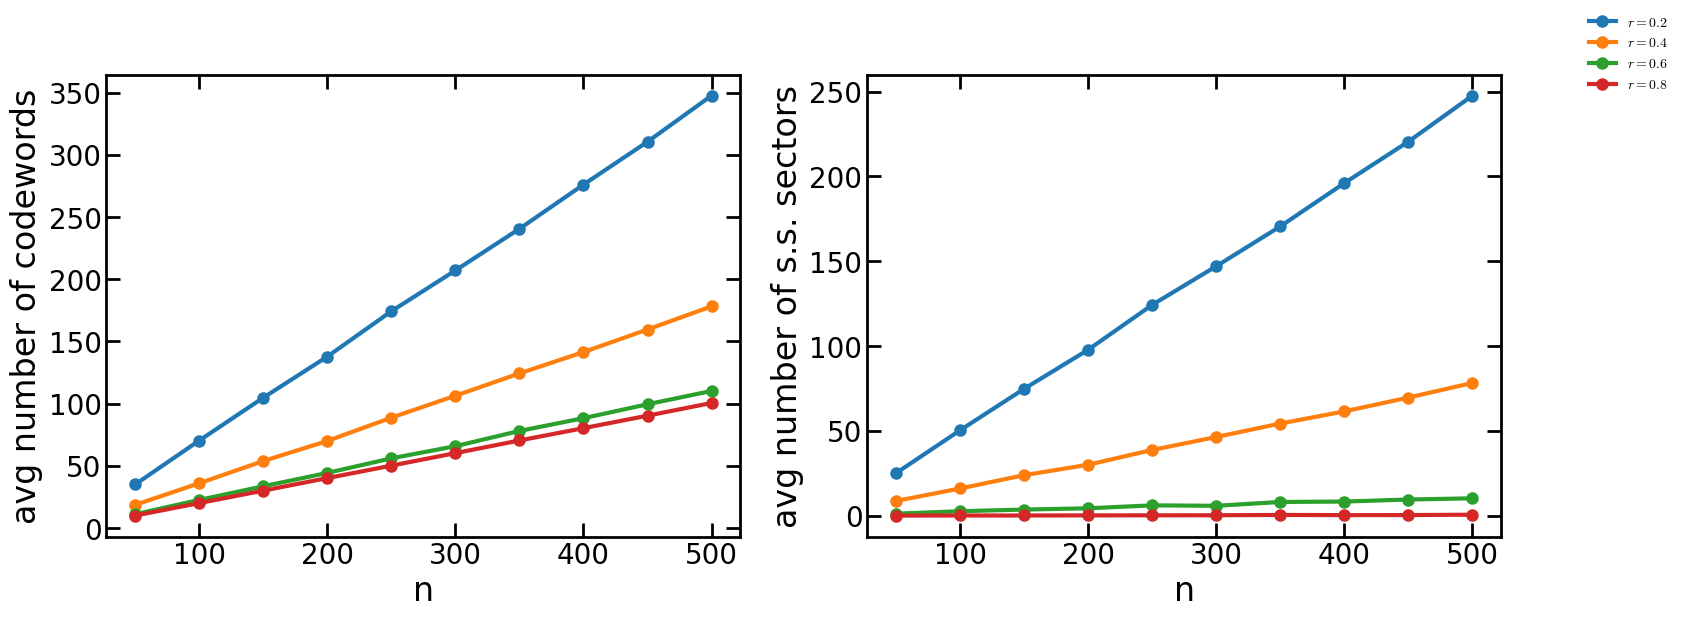

In [157]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(ns, avg_dimkers['r0.2'], 'o-', label='$r=0.2$')
ax[0].plot(ns, avg_dimkers['r0.4'], 'o-', label='$r=0.4$')
ax[0].plot(ns, avg_dimkers['r0.6'], 'o-', label='$r=0.6$')
ax[0].plot(ns, avg_dimkers['r0.8'], 'o-', label='$r=0.8$')
ax[0].set_xlabel('n')
ax[0].set_ylabel('avg number of codewords')
# ax[0].set_title('avg dim ker vs n')
ax[1].plot(ns, avg_dimcoimgs['r0.2'], 'o-')
ax[1].plot(ns, avg_dimcoimgs['r0.4'], 'o-')
ax[1].plot(ns, avg_dimcoimgs['r0.6'], 'o-')
ax[1].plot(ns, avg_dimcoimgs['r0.8'], 'o-')
ax[1].set_xlabel('n')
ax[1].set_ylabel('avg number of s.s. sectors')
# ax[1].set_title('avg number of superselection sectors vs n')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
fig.set_size_inches(18, 6)
fig.savefig('../figures/local_ldpc_code_dim_scaling.pdf')
plt.show()

### Minimum distance scaling
[reference](https://digital.library.unt.edu/ark:/67531/metadc743246/m2/1/high_res_d/794005.pdf)

#### Before rescaling

In [ ]:
r = 0.8
min_dists = []
avg_min_dists = []
for i, size in enumerate(sizes):
    min_dists.append([])
    for j, seed in enumerate(seeds):
        readpath = os.path.join(readdir, f'mindist_n{ns[i]}_m{ms[i]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed}.npy')
        min_dist = np.load(readpath)
        min_dists[-1].append(min_dist)
    avg_min_dists.append(np.mean(min_dists[-1]))

In [ ]:
def inverse_sqrt(x, a):
    return a/np.sqrt(x)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(inverse_sqrt, ns, avg_min_dists)

#### After rescaling

In [ ]:
r = 0.8
min_dists_rescaled = []
avg_min_dists_rescaled = []
for i, size in enumerate(sizes):
    min_dists_rescaled.append([])
    for j, seed in enumerate(seeds):
        readpath = os.path.join(readdir, f'mindist_rescaled_n{ns[i]}_m{ms[i]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed}.npy')
        min_dist = np.load(readpath)
        min_dists_rescaled[-1].append(min_dist)
    avg_min_dists_rescaled.append(np.mean(min_dists_rescaled[-1]))

In [ ]:
fig, ax = plt.subplots(1, 2)
# left plot: unrescaled
ax[0].fill_between(ns, avg_min_dists-np.std(min_dists, axis=1), avg_min_dists+np.std(min_dists, axis=1), alpha=0.2, label='standard deviation')
ax[0].plot(ns, avg_min_dists, 'o-', label='avg min dist')
ax[0].plot(ns, popt/np.sqrt(ns), label='1/sqrt(n)')
ax[0].set_xlabel('n')
ax[0].set_ylabel('avg min dist (unrescaled)')
ax[0].set_title('unrescaled')
# right plot: rescaled
ax[1].fill_between(ns, avg_min_dists_rescaled-np.std(min_dists_rescaled, axis=1), avg_min_dists_rescaled+np.std(min_dists_rescaled, axis=1), alpha=0.2)
ax[1].plot(ns, avg_min_dists_rescaled, 'o-')
ax[1].set_xlabel('n')
ax[1].set_ylabel('avg min dist (rescaled)')
ax[1].set_title('rescaled')
fig.legend()
fig.set_size_inches(22, 8)
fig.savefig('../figures/rgg_avg_min_dist.pdf')
plt.show()

### Scaling of hypergraph product quantum codes
Formula for number of superselection sectors:
$m_X - rank(H_X)=m_1 n_2 - $ for Z-type excitations; $m_Z - rank(H_Z)$ for X-type excitations.

BPT bound: $kd^2=O(n)$

In [13]:
sizes_for_qcode = np.array(range(10, 40, 10))
r = 0.2
seed1 = 0
seed2 = 20
dimkers = {'r0.2': []}
dimcoimgs_X = {'r0.2': []}
dimcoimgs_Z = {'r0.2': []}
for isize, size in enumerate(sizes_for_qcode):
    readpath1 = os.path.join(readdir, f'hclassical_n{ns[isize]}_m{ms[isize]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed1}.txt')
    h1 = read_pc(readpath1)
    readpath2 = os.path.join(readdir, f'hclassical_n{ns[isize]}_m{ms[isize]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed2}.txt')
    h2 = read_pc(readpath2)
    qcode = hgp(h1=h1, h2=h2)
    hx, hz = qcode.hx, qcode.hz
    dimkers['r0.2'].append(qcode.K)
    dimcoimgs_X['r0.2'].append(hx.shape[0] - len(row_basis(hx)))
    dimcoimgs_Z['r0.2'].append(hz.shape[0] - len(row_basis(hz)))

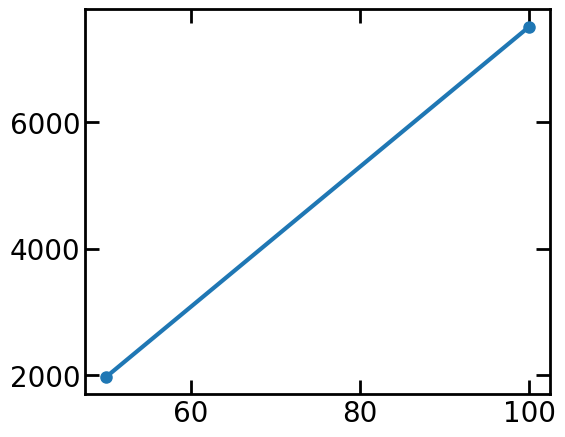

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(sizes_for_qcode*deg_check, dimkers['r0.2'], 'o-', label='dim ker ($r=0.2$))')
# fig.set_size_inches(18, 18)
fig.savefig('../figures/local_qldpc_dim_scaling.pdf')
plt.show()

### Confinement (discrete compressed sensing)
Setting: classical, nolocality

In [8]:
sizes = range(20, 21, 1)
seeds = [0]
deg_bit = 4
deg_check = 5
size = sizes[0]
seed = seeds[0]
n = deg_check*size
m = deg_bit*size

readname = f'hclassical_nolocality_n={n}_m={m}_degbit={deg_bit}_degcheck={deg_check}_seed={seed}.txt'
h = read_pc(os.path.join(readdir, readname))

In [9]:
rng = np.random.default_rng(0)
nsamples = 1000
error_weights = np.arange(1, h.shape[1], 1)
synd_weights_list = []
for error_weight in error_weights:
    error_vecs = np.zeros((nsamples, h.shape[1]), dtype=int)
    # synd_vecs = np.zeros((nsamples, h.shape[0]), dtype=int)
    for i in range(nsamples):
        posones = rng.choice(range(h.shape[1]), size=error_weight, replace=False)
        error_vecs[i, posones] = 1
    synd_vecs = np.mod(error_vecs@(h.T), 2)
    synd_weights = np.sum(synd_vecs, axis=1)
    synd_weights_list.append(synd_weights)


In [10]:
synd_weights_avg = np.mean(synd_weights_list, axis=1)
synd_weights_std = np.std(synd_weights_list, axis=1)
synd_weights_max = np.max(synd_weights_list, axis=1)
synd_weights_min = np.min(synd_weights_list, axis=1)

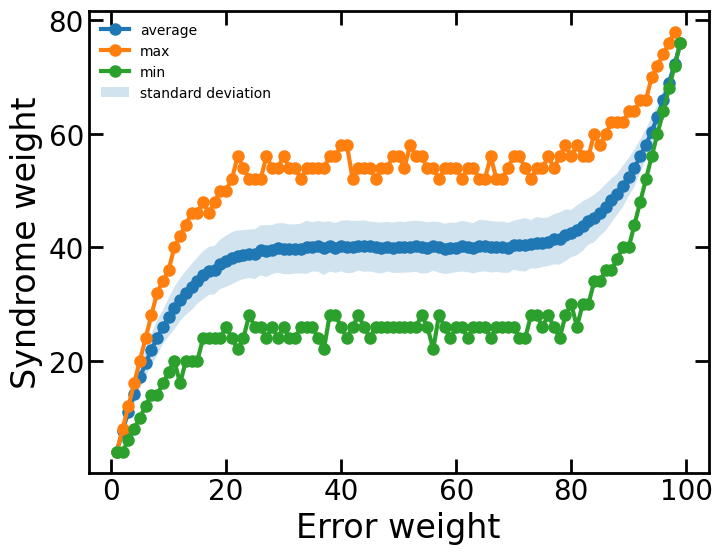

In [11]:
fig, ax = plt.subplots()
# ax.errorbar(error_weights, synd_weights_avg, yerr=synd_weights_std, fmt='o-', capsize=2)
ax.plot(error_weights, synd_weights_avg, 'o-', label='average')
ax.plot(error_weights, synd_weights_max, 'o-', label='max')
ax.plot(error_weights, synd_weights_min, 'o-', label='min')
ax.fill_between(error_weights, synd_weights_avg-synd_weights_std, synd_weights_avg+synd_weights_std, alpha=0.2, label='standard deviation')
ax.set_xlabel('Error weight')
ax.set_ylabel('Syndrome weight')
ax.legend()
fig.set_size_inches(8, 6)
fig.savefig(f'../figures/synd_weight_vs_error_weight_hclassical_nolocality_n={n}_m={m}_degbit={deg_bit}_degcheck={deg_check}_seed={seed}.pdf')
plt.show()

### Confinement II (discrete compressed sensing)
Setting: classical, local, no parallel edges

In [12]:
sizes = range(10, 11, 1)
seeds = [0]
deg_bit = 8
deg_check = 10
size = sizes[0]
seed = seeds[0]
n = deg_check*size
m = deg_bit*size

readname = f'hclassical_noprledgelocal_n={n}_m={m}_degbit={deg_bit}_degcheck={deg_check}_seed={seed}.txt'
h = read_pc(os.path.join(readdir, readname))

In [13]:
rng = np.random.default_rng(0)
nsamples = 1000
error_weights = np.arange(1, h.shape[1], 1)
synd_weights_list = []
for error_weight in error_weights:
    error_vecs = np.zeros((nsamples, h.shape[1]), dtype=int)
    # synd_vecs = np.zeros((nsamples, h.shape[0]), dtype=int)
    for i in range(nsamples):
        posones = rng.choice(range(h.shape[1]), size=error_weight, replace=False)
        error_vecs[i, posones] = 1
    synd_vecs = np.mod(error_vecs@(h.T), 2)
    synd_weights = np.sum(synd_vecs, axis=1)
    synd_weights_list.append(synd_weights)


In [14]:
synd_weights_avg = np.mean(synd_weights_list, axis=1)
synd_weights_std = np.std(synd_weights_list, axis=1)
synd_weights_max = np.max(synd_weights_list, axis=1)
synd_weights_min = np.min(synd_weights_list, axis=1)

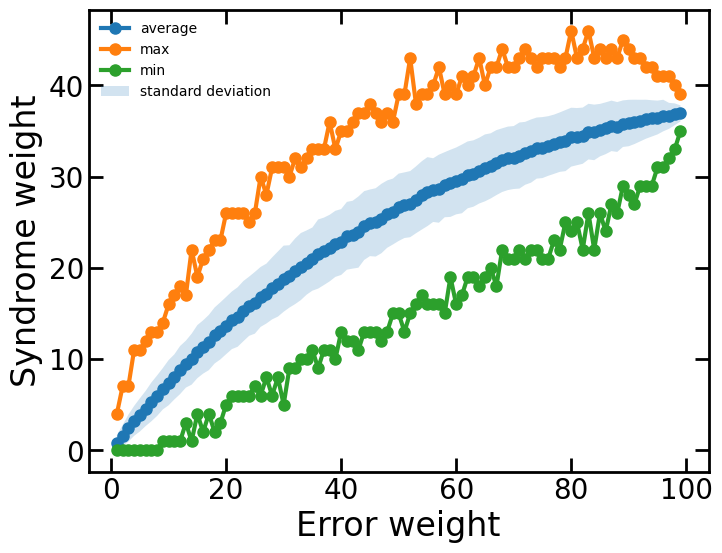

In [15]:
fig, ax = plt.subplots()
# ax.errorbar(error_weights, synd_weights_avg, yerr=synd_weights_std, fmt='o-', capsize=2)
ax.plot(error_weights, synd_weights_avg, 'o-', label='average')
ax.plot(error_weights, synd_weights_max, 'o-', label='max')
ax.plot(error_weights, synd_weights_min, 'o-', label='min')
ax.fill_between(error_weights, synd_weights_avg-synd_weights_std, synd_weights_avg+synd_weights_std, alpha=0.2, label='standard deviation')
ax.set_xlabel('Error weight')
ax.set_ylabel('Syndrome weight')
ax.legend()
fig.set_size_inches(8, 6)
fig.savefig(f'../figures/synd_weight_vs_error_weight_hclassical_noprledgelocal_n={n}_m={m}_degbit={deg_bit}_degcheck={deg_check}_seed={seed}.pdf')
plt.show()

### Degree sequence heatmap

In [17]:
import json

In [53]:
sizes = range(30, 31, 1)
rs = [0.4]
seeds = [4]
deg_bit = 8
deg_check = 10
size = sizes[0]
r = rs[0]
seed = seeds[0]
n = deg_check*size
m = deg_bit*size
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/rgg_code'
readname_pc = f'hclassical_noprledgelocal_n={n}_m={m}_degbit={deg_bit}_degcheck={deg_check}_r={r}_seed={seed}.txt'
readname_pos = f'pos_noprledgelocal_n={n}_m={m}_degbit={deg_bit}_degcheck={deg_check}_r={r}_seed={seed}.json'
h = read_pc(os.path.join(readdir, readname_pc))
with open(os.path.join(readdir, readname_pos), 'r') as f:
    pos = json.load(f)

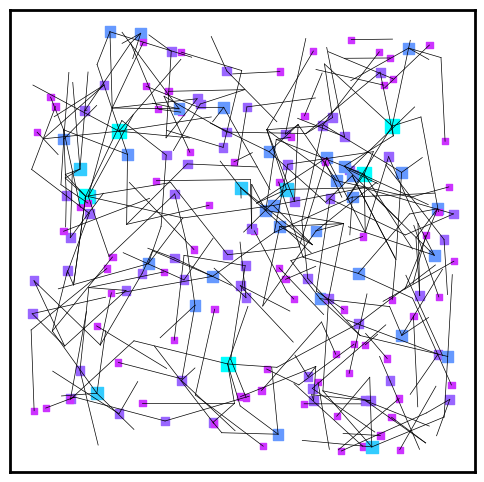

In [65]:
pos_nodes = [pos[str(i)] for i in range(n)]
pos_checks = [pos[str(i)] for i in range(n, n+m)]
fig, ax= plt.subplots()
for edge in zip(*h.nonzero()):
    ax.plot(*zip(pos_nodes[edge[1]], pos_checks[edge[0]]), color='k', linestyle='-', linewidth=0.5)
deg_checks = np.sum(h, axis=1)
colors = 1 - deg_checks/deg_check
ax.scatter(*zip(*pos_checks), marker='s', s=deg_checks*20, c=colors, cmap='cool')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.set_size_inches(6, 6)
fig.savefig(f'../figures/connection_noprledgelocal_n={n}_m={m}_degbit={deg_bit}_degcheck={deg_check}_r={r}_seed={seed}.pdf')

### Kernel and superselection scaling of Laplacian code II
Setting: $d$-regular graphs on $n$ nodes

In [142]:
ns = np.array([10, 16, 20, 24, 32, 40])
seeds = np.array(range(0, 21))
ds_m1 = ns - 1
ds_m2 = ns - 2
ds_m3 = ns - 3
ds_m4 = ns - 4
dimkers_m1 = []
dimkers_m2 = []   
dimkers_m3 = []   
dimkers_m4 = []   
dimcoimgs_m1 = [] 
dimcoimgs_m2 = [] 
dimcoimgs_m3 = [] 
dimcoimgs_m4 = [] 

readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'

for i_n, n in enumerate(ns):
    dimkers_m1.append([])
    dimkers_m2.append([])
    dimkers_m3.append([])
    dimkers_m4.append([])
    dimcoimgs_m1.append([])
    dimcoimgs_m2.append([])
    dimcoimgs_m3.append([])
    dimcoimgs_m4.append([])
    for seed in seeds:
        readname_m4 = f'hclassical_randomregular_n={n}_d={ds_m4[i_n]}_seed={seed}.txt'
        readname_m3 = f'hclassical_randomregular_n={n}_d={ds_m3[i_n]}_seed={seed}.txt'
        readname_m2 = f'hclassical_randomregular_n={n}_d={ds_m2[i_n]}_seed={seed}.txt'
        readname_m1 = f'hclassical_randomregular_n={n}_d={ds_m1[i_n]}_seed={seed}.txt'
        h_m4 = read_pc(os.path.join(readdir, readname_m4))
        h_m3 = read_pc(os.path.join(readdir, readname_m3))
        h_m2 = read_pc(os.path.join(readdir, readname_m2))
        h_m1 = read_pc(os.path.join(readdir, readname_m1))
        dimkers_m4[-1].append(len(nullspace(h_m4)))
        dimkers_m3[-1].append(len(nullspace(h_m3)))
        dimkers_m2[-1].append(len(nullspace(h_m2)))
        dimkers_m1[-1].append(len(nullspace(h_m1)))
        dimcoimgs_m4[-1].append(h_m4.shape[0] - rank(h_m4))
        dimcoimgs_m3[-1].append(h_m3.shape[0] - rank(h_m3))
        dimcoimgs_m2[-1].append(h_m2.shape[0] - rank(h_m2))
        dimcoimgs_m1[-1].append(h_m1.shape[0] - rank(h_m1))

In [143]:
avg_dimkers_m4 = np.mean(dimkers_m4, axis=1)
avg_dimkers_m3 = np.mean(dimkers_m3, axis=1)
avg_dimkers_m2 = np.mean(dimkers_m2, axis=1)
avg_dimkers_m1 = np.mean(dimkers_m1, axis=1)
avg_dimcoimgs_m4 = np.mean(dimcoimgs_m4, axis=1)
avg_dimcoimgs_m3 = np.mean(dimcoimgs_m3, axis=1)
avg_dimcoimgs_m2 = np.mean(dimcoimgs_m2, axis=1)
avg_dimcoimgs_m1 = np.mean(dimcoimgs_m1, axis=1)
std_dimkers_m4 = np.std(dimkers_m4, axis=1)
std_dimkers_m3 = np.std(dimkers_m3, axis=1)
std_dimkers_m2 = np.std(dimkers_m2, axis=1)
std_dimkers_m1 = np.std(dimkers_m1, axis=1)
std_dimcoimgs_m4 = np.std(dimcoimgs_m4, axis=1)
std_dimcoimgs_m3 = np.std(dimcoimgs_m3, axis=1)
std_dimcoimgs_m2 = np.std(dimcoimgs_m2, axis=1)
std_dimcoimgs_m1 = np.std(dimcoimgs_m1, axis=1)

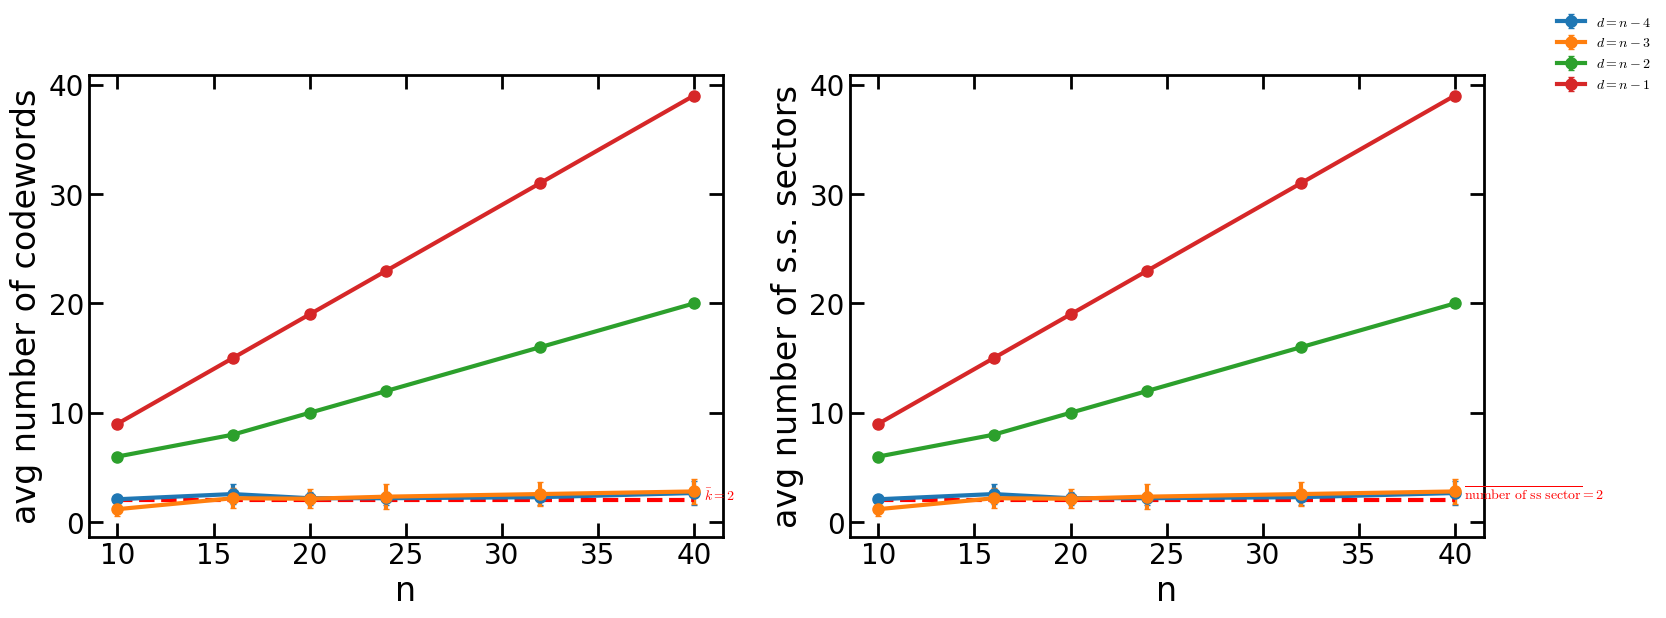

In [144]:
fig, ax = plt.subplots(1, 2)
ax[0].errorbar(ns, avg_dimkers_m4, yerr=std_dimkers_m4, fmt='o-', capsize=2, label='$d=n-4$')
ax[0].errorbar(ns, avg_dimkers_m3, yerr=std_dimkers_m3, fmt='o-', capsize=2, label='$d=n-3$')
ax[0].errorbar(ns, avg_dimkers_m2, yerr=std_dimkers_m2, fmt='o-', capsize=2, label='$d=n-2$')
ax[0].errorbar(ns, avg_dimkers_m1, yerr=std_dimkers_m1, fmt='o-', capsize=2, label='$d=n-1$')
ax[0].hlines(2, ns[0], ns[-1], colors='r', linestyles='dashed')
ax[0].annotate('$\\bar{k}=2$', xy=(ns[-1], 2), xytext=(ns[-1]+0.5, 2), color='r')
ax[0].set_xlabel('n')
ax[0].set_ylabel('avg number of codewords')
ax[1].errorbar(ns, avg_dimcoimgs_m4, yerr=std_dimcoimgs_m4, fmt='o-', capsize=2)
ax[1].errorbar(ns, avg_dimcoimgs_m3, yerr=std_dimcoimgs_m3, fmt='o-', capsize=2)
ax[1].errorbar(ns, avg_dimcoimgs_m2, yerr=std_dimcoimgs_m2, fmt='o-', capsize=2)
ax[1].errorbar(ns, avg_dimcoimgs_m1, yerr=std_dimcoimgs_m1, fmt='o-', capsize=2)
ax[1].hlines(2, ns[0], ns[-1], colors='r', linestyles='dashed')
ax[1].annotate('$\overline{\\rm{number\ of\ ss\ sector}}=2$', xy=(ns[-1], 2), xytext=(ns[-1]+0.5, 2), color='r')
ax[1].set_xlabel('n')
ax[1].set_ylabel('avg number of s.s. sectors')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
fig.set_size_inches(18, 6)
fig.savefig('../figures/laplacian_code_dim_scaling.pdf')
plt.show()

### Confinement III
Setting: Laplacian code generated using $d$-regular graphs on $n$ nodes

In [104]:
n = 40
ds = range(n-4,n)
seed = 13

readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
readname_m4 = f'hclassical_randomregular_n={n}_d={ds[0]}_seed={seed}.txt'
readname_m3 = f'hclassical_randomregular_n={n}_d={ds[1]}_seed={seed}.txt'
readname_m2 = f'hclassical_randomregular_n={n}_d={ds[2]}_seed={seed}.txt'
readname_m1 = f'hclassical_randomregular_n={n}_d={ds[3]}_seed={seed}.txt'
h_m4 = read_pc(os.path.join(readdir, readname_m4))
h_m3 = read_pc(os.path.join(readdir, readname_m3))
h_m2 = read_pc(os.path.join(readdir, readname_m2))
h_m1 = read_pc(os.path.join(readdir, readname_m1))

In [105]:
rng = np.random.default_rng(0)
nsamples = 1000
error_weights = np.arange(1, n, 1)
synd_weights_list_m4 = []
synd_weights_list_m3 = []
synd_weights_list_m2 = []
synd_weights_list_m1 = []

for error_weight in error_weights:
    error_vecs = np.zeros((nsamples, n), dtype=int)
    for i in range(nsamples):
        posones = rng.choice(range(n), size=error_weight, replace=False)
        error_vecs[i, posones] = 1
    synd_vecs_m4 = np.mod(error_vecs@(h_m4.T), 2)
    synd_weights_m4 = np.sum(synd_vecs_m4, axis=1)
    synd_weights_list_m4.append(synd_weights_m4)

    synd_vecs_m3 = np.mod(error_vecs@(h_m3.T), 2)
    synd_weights_m3 = np.sum(synd_vecs_m3, axis=1)
    synd_weights_list_m3.append(synd_weights_m3)

    synd_vecs_m2 = np.mod(error_vecs@(h_m2.T), 2)
    synd_weights_m2 = np.sum(synd_vecs_m2, axis=1)
    synd_weights_list_m2.append(synd_weights_m2)

    synd_vecs_m1 = np.mod(error_vecs@(h_m1.T), 2)
    synd_weights_m1 = np.sum(synd_vecs_m1, axis=1)
    synd_weights_list_m1.append(synd_weights_m1)

synd_weights_avg_m4 = np.mean(synd_weights_list_m4, axis=1)
synd_weights_std_m4 = np.std(synd_weights_list_m4, axis=1)
synd_weights_max_m4 = np.max(synd_weights_list_m4, axis=1)
synd_weights_min_m4 = np.min(synd_weights_list_m4, axis=1)
synd_weights_avg_m3 = np.mean(synd_weights_list_m3, axis=1)
synd_weights_std_m3 = np.std(synd_weights_list_m3, axis=1)
synd_weights_max_m3 = np.max(synd_weights_list_m3, axis=1)
synd_weights_min_m3 = np.min(synd_weights_list_m3, axis=1)
synd_weights_avg_m2 = np.mean(synd_weights_list_m2, axis=1)
synd_weights_std_m2 = np.std(synd_weights_list_m2, axis=1)
synd_weights_max_m2 = np.max(synd_weights_list_m2, axis=1)
synd_weights_min_m2 = np.min(synd_weights_list_m2, axis=1)
synd_weights_avg_m1 = np.mean(synd_weights_list_m1, axis=1)
synd_weights_std_m1 = np.std(synd_weights_list_m1, axis=1)
synd_weights_max_m1 = np.max(synd_weights_list_m1, axis=1)
synd_weights_min_m1 = np.min(synd_weights_list_m1, axis=1)

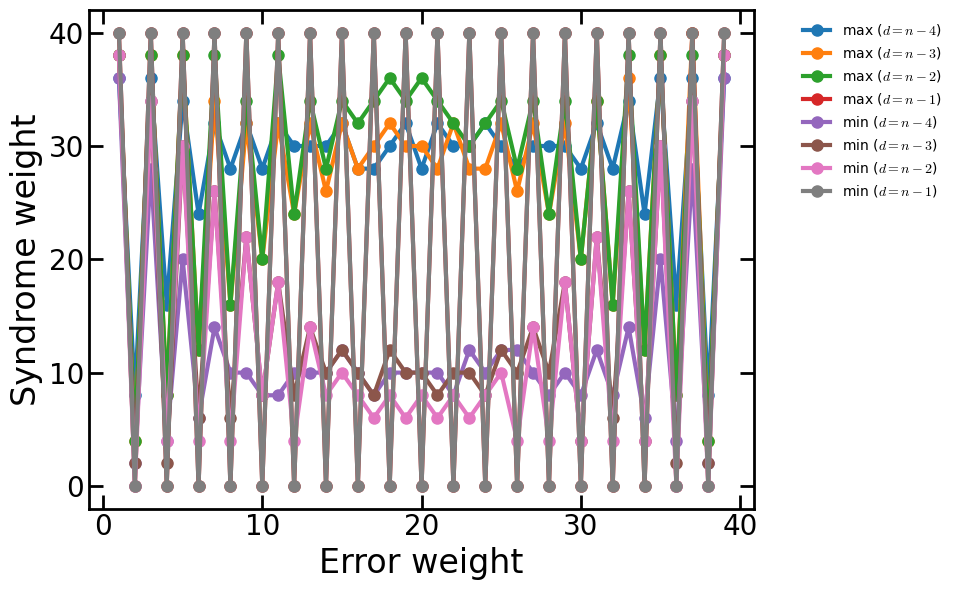

In [111]:
fig, ax = plt.subplots()
# ax.plot(error_weights, synd_weights_avg_m4, 'o-', label='$d=n-4$')
# ax.plot(error_weights, synd_weights_avg_m3, 'o-', label='$d=n-3$')
# ax.plot(error_weights, synd_weights_avg_m2, 'o-', label='$d=n-2$')
# ax.plot(error_weights, synd_weights_avg_m1, 'o-', label='$d=n-1$')
# ax.fill_between(error_weights, synd_weights_avg_m4-synd_weights_std_m4, synd_weights_avg_m4+synd_weights_std_m4, alpha=0.2)
# ax.fill_between(error_weights, synd_weights_avg_m3-synd_weights_std_m3, synd_weights_avg_m3+synd_weights_std_m3, alpha=0.2)
# ax.fill_between(error_weights, synd_weights_avg_m2-synd_weights_std_m2, synd_weights_avg_m2+synd_weights_std_m2, alpha=0.2)
# ax.fill_between(error_weights, synd_weights_avg_m1-synd_weights_std_m1, synd_weights_avg_m1+synd_weights_std_m1, alpha=0.2)
ax.plot(error_weights, synd_weights_max_m4, 'o-', label='max ($d=n-4$)')
ax.plot(error_weights, synd_weights_max_m3, 'o-', label='max ($d=n-3$)')
ax.plot(error_weights, synd_weights_max_m2, 'o-', label='max ($d=n-2$)')
ax.plot(error_weights, synd_weights_max_m1, 'o-', label='max ($d=n-1$)')
ax.plot(error_weights, synd_weights_min_m4, 'o-', label='min ($d=n-4$)')
ax.plot(error_weights, synd_weights_min_m3, 'o-', label='min ($d=n-3$)')
ax.plot(error_weights, synd_weights_min_m2, 'o-', label='min ($d=n-2$)')
ax.plot(error_weights, synd_weights_min_m1, 'o-', label='min ($d=n-1$)')
ax.set_xlabel('Error weight')
ax.set_ylabel('Syndrome weight')
# set the position of the legend to be top-right and oustide the plot
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)
fig.set_size_inches(10, 6)
fig.tight_layout()
fig.savefig(f'../figures/synd_weight_vs_error_weight_laplacian_code_randomregular_n={n}_seed={seed}.pdf')
plt.show()

### Dim scaling III (debug)
Setting: Shu-Heng Shao's example defining Laplacian code on a square lattice


In [2]:
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
Ls = range(10, 21, 1)
dimkers = []
dimcoimgs = []
for L in Ls:
    readname = f'hclassical_shs_squarelattice_L={L}.txt'
    h = read_pc(os.path.join(readdir, readname))
    dimkers.append(len(nullspace(h)))
    dimcoimgs.append(h.shape[0] - rank(h))

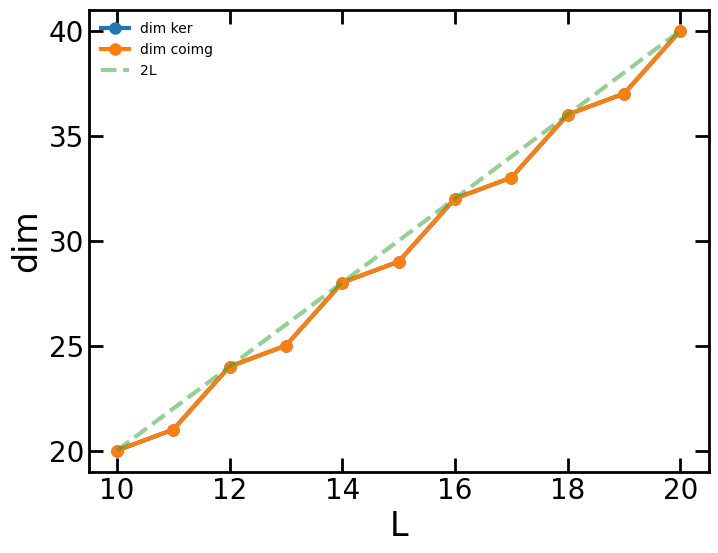

In [8]:
fig, ax = plt.subplots()
ax.plot(Ls, dimkers, 'o-', label='dim ker')
ax.plot(Ls, dimcoimgs, 'o-', label='dim coimg')
# change the dim = 2L plot to dashed line and opacify it
ax.plot(Ls, [2*L for L in Ls], label='2L', linestyle='dashed', alpha=0.5)
ax.set_xlabel('L')
ax.set_ylabel('dim')
ax.legend()
fig.set_size_inches(8, 6)
fig.savefig('../figures/shs_squarelattice_dim_scaling.pdf')
plt.show()

### Confinement IV
Setting: Laplacian code SHS

In [14]:
L = 20

readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
readname = f'hclassical_shs_squarelattice_L={L}.txt'
h = read_pc(os.path.join(readdir, readname))

rng = np.random.default_rng(0)
nsamples = 1000
error_weights = np.arange(0, L**2+1, 1)
synd_weights_list = []
for error_weight in error_weights:
    error_vecs = np.zeros((nsamples, L**2), dtype=int)
    for i in range(nsamples):
        posones = rng.choice(range(L**2), size=error_weight, replace=False)
        error_vecs[i, posones] = 1
    synd_vecs = np.mod(error_vecs@(h.T), 2)
    synd_weights = np.sum(synd_vecs, axis=1)
    synd_weights_list.append(synd_weights)
synd_weights_avg = np.mean(synd_weights_list, axis=1)
synd_weights_std = np.std(synd_weights_list, axis=1)
synd_weights_max = np.max(synd_weights_list, axis=1)
synd_weights_min = np.min(synd_weights_list, axis=1)

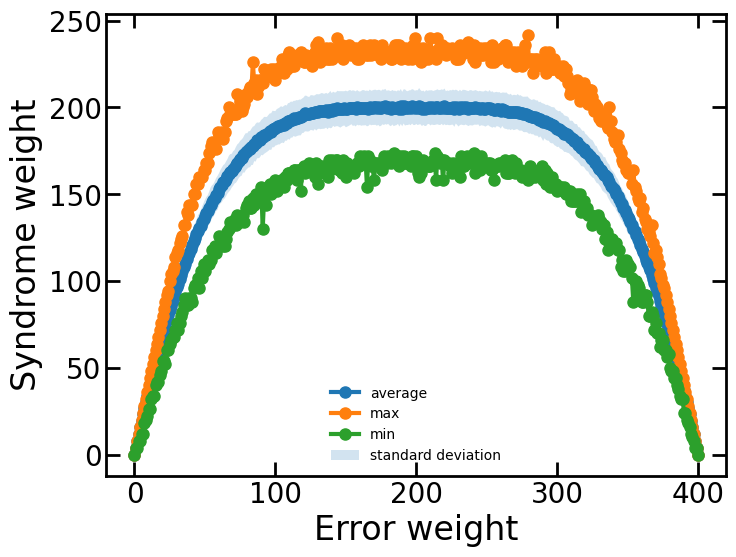

In [13]:
fig, ax = plt.subplots()
ax.plot(error_weights, synd_weights_avg, 'o-', label='average')
ax.plot(error_weights, synd_weights_max, 'o-', label='max')
ax.plot(error_weights, synd_weights_min, 'o-', label='min')
ax.fill_between(error_weights, synd_weights_avg-synd_weights_std, synd_weights_avg+synd_weights_std, alpha=0.2, label='standard deviation')
ax.set_xlabel('Error weight')
ax.set_ylabel('Syndrome weight')
ax.legend()
fig.set_size_inches(8, 6)
fig.savefig(f'../figures/synd_weight_vs_error_weight_shs_squarelattice_n={L}.pdf')
plt.show()

### Visualization of logical bits in the base Laplacian code

In [17]:
L = 10
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/laplacian_code'
readname = f'hclassical_shs_squarelattice_L={L}.txt'
h = read_pc(os.path.join(readdir, readname))

logical_basis = nullspace(h)

20

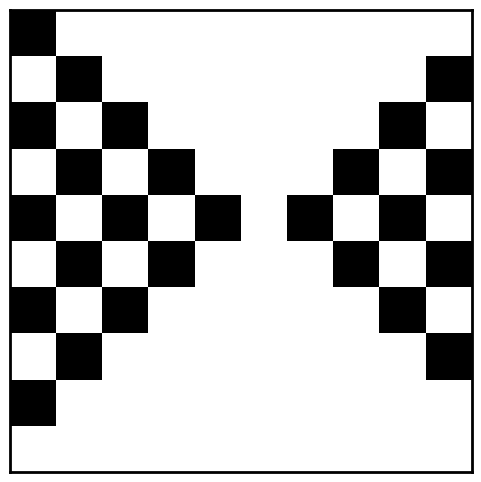

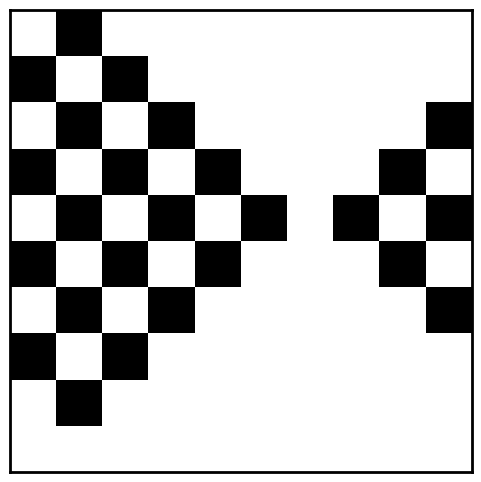

In [31]:
for i in range(len(logical_basis[:2])):
    # plot the logical operator
    logical_visualize = logical_basis[i].reshape((L, L))
    fig, ax = plt.subplots()
    ax.imshow(logical_visualize, cmap='gray_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.set_size_inches(6, 6)
    # fig.savefig(f'../figures/logical_operator_shs_squarelattice_n={L}_i={i}.pdf')
    plt.show()

### Smith decomposition
Just sanity check to see the typical behavior of Laplacian codes

In [139]:
from sympy import Matrix, ZZ, GF
from sympy.matrices.normalforms import smith_normal_form

from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
session = WolframLanguageSession()

def ndarr_to_mathematica(ndarr):
    return str(ndarr.tolist()).replace('[','{').replace(']','}')

def SmithDecomposition_command(ndarr):
    arr_str = ndarr_to_mathematica(ndarr)
    return f"SmithDecomposition[{arr_str}]"

def Evaluate_SmihtDecomposition(ndarr):
    command = SmithDecomposition_command(ndarr)
    return session.evaluate(wlexpr(command))

def easy_to_read_SmithDecomposition(ndarr):
    result = Evaluate_SmihtDecomposition(ndarr)
    return np.diag(result[1])

Setting: the Laplacian I wrote down in the slides

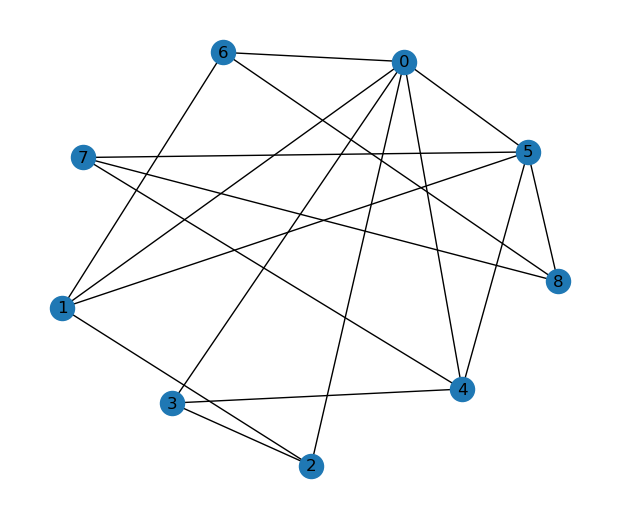

In [155]:
G = nx.empty_graph(9)
pos = nx.spring_layout(G, seed=1)
edgelist = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6),
            (1,0), (1,2), (1,5), (1,6),
            (2,0), (2,1), (2,3),
            (3,0), (3,2), (3,4),
            (4,0), (4,3), (4,5), (4,7),
            (5,0), (5,1), (5,4), (5,7), (5,8),
            (6,0), (6,1), (6,8),
            (7,4), (7,5), (7,8),
            (8,5), (8,6), (8,7)]
G.add_edges_from(edgelist)
nx.draw(G, pos, with_labels=True)
plt.show()

laplacian = nx.laplacian_matrix(G).toarray()
laplacian_eigvals, laplacian_eigvecs = np.linalg.eigh(laplacian)
assert np.allclose(laplacian_eigvals[0],0)

In [159]:
m = Matrix(laplacian)
smith_normal_form(m, domain=ZZ)

Matrix([
[1, 0, 0, 0, 0, 0, 0,    0, 0],
[0, 1, 0, 0, 0, 0, 0,    0, 0],
[0, 0, 1, 0, 0, 0, 0,    0, 0],
[0, 0, 0, 1, 0, 0, 0,    0, 0],
[0, 0, 0, 0, 1, 0, 0,    0, 0],
[0, 0, 0, 0, 0, 1, 0,    0, 0],
[0, 0, 0, 0, 0, 0, 1,    0, 0],
[0, 0, 0, 0, 0, 0, 0, 4741, 0],
[0, 0, 0, 0, 0, 0, 0,    0, 0]])

In [160]:
easy_to_read_SmithDecomposition(laplacian)

array([   1,    1,    1,    1,    1,    1,    1, 4741,    0])

Setting: Laplacians of random graphs

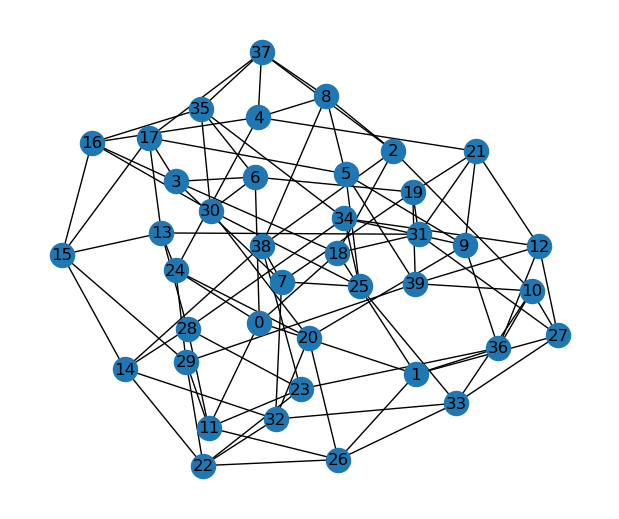

In [191]:
seed = 1
n, d = 40, 5
G = nx.random_regular_graph(d, n, seed=seed)
nx.draw(G, with_labels=True)

In [190]:
laplacian = nx.laplacian_matrix(G).toarray()
laplacian_eigvals, laplacian_eigvecs = np.linalg.eigh(laplacian)
assert np.allclose(laplacian_eigvals[0],0)
m = Matrix(laplacian)
print('Mathematica:', easy_to_read_SmithDecomposition(laplacian))
smith_normal_form(m, domain=ZZ)

KeyboardInterrupt: 